In [18]:
# !pip install python-docx
# 0.8.11

In [78]:
# !pip install PyPDF2
# 2-2.12.1

In [79]:
# brew update
# brew install --cask libreoffice
# version: LibreOffice 7.3.4.2 728fec16bd5f605073805c3c9e7c4212a0120dc5

In [364]:
# !pip install striprtf
# 0.0.22

In [365]:
# !pip install lime
# 0.2.0.1

In [36]:
import pandas as pd
import numpy as np
import json
import os
import re
import docx
import subprocess

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
import pickle

from PyPDF2 import PdfReader
from striprtf.striprtf import rtf_to_text

from pymystem3 import Mystem
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
########################## инициализация глобальных переменных ##########################
toktok = ToktokTokenizer()
stemmer = RussianStemmer()
m = Mystem()
russian_stopwords = nltk.corpus.stopwords.words('russian')
russian_stopwords.append('страница')

DOC_PATH = '/Users/mayabikmetova/xmas/hacka-aka-embedika/docs'

In [10]:
def getText(filename):
    doc = docx.Document(filename)
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    return '\n'.join(fullText)

In [11]:
# Проведем очистку данных: стемминг, единый регистр, удалим знаки препинания, цифры и т.п.

def preprocess(line):
    """
    Функция предобработки текста:
    - очищает текст от цифр и лишних знаков препинания,
    - удаляет короткие слова (состоящие из 1 буквы),
    - удаяет стоп-слова,
    - проводит лемматизацию
    """
    char_regex = re.compile(r'[^а-яa-z]')
    line = char_regex.sub(' ', line.lower())
    
    short_words = re.compile(r'\b[а-яa-z]{1}\b')
    line = short_words.sub(' ', line.lower())
    
    tokenized = toktok.tokenize(line)
    stemmed_str = []
    for i in tokenized:
        if i not in russian_stopwords:
            lemma = m.lemmatize(i)[0]
            stemmed_str.append(str(lemma))
#         stemmed = stemmer.stem(i)
#         stemmed_str += str(stemmed + ' ')
    return ' '.join(stemmed_str)

In [121]:
################ конвертация doc в docx для дальнейшего прочтения ################

# for FILE in os.listdir(DOC_PATH):
#     if FILE.split('.')[1] == 'doc':
#         subprocess.call(["cd {} && /Applications/LibreOffice.app/Contents/MacOS/soffice \
#                          --headless --convert-to docx {} && rm {}".format(DOC_PATH, FILE, FILE)],
#                          shell=True)
#         print('Конвертирован файл ', FILE)


convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/02682d726b725f95b9ee85f751c043d0.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/02682d726b725f95b9ee85f751c043d0.docx using filter : Office Open XML Text
Конвертирован файл  02682d726b725f95b9ee85f751c043d0.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/2c81df29db63aebf495106881a52188f.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/2c81df29db63aebf495106881a52188f.docx using filter : Office Open XML Text
Конвертирован файл  2c81df29db63aebf495106881a52188f.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/31d24c0d4694e7c2fb19933b84414b40.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/31d24c0d4694e7c2fb19933b84414b40.docx using filter : Office Open XML Text
Конвертирован файл  31d24c0d4694e7c2fb19933b84414b40.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/57962abd8dbe0ce0c7056896ee4501f1.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/57962abd8dbe0ce

Конвертирован файл  49bce5af1c98cd017a310ea8edd3e55b.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/a0e06a957c1a729fe1d978605680e2ae.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/a0e06a957c1a729fe1d978605680e2ae.docx using filter : Office Open XML Text
Конвертирован файл  a0e06a957c1a729fe1d978605680e2ae.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/073a0d372820c3c2bffe9ba24a7ed7af.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/073a0d372820c3c2bffe9ba24a7ed7af.docx using filter : Office Open XML Text
Конвертирован файл  073a0d372820c3c2bffe9ba24a7ed7af.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/7ecd641f2ad81961c17455ed3ebeb2ab.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/7ecd641f2ad81961c17455ed3ebeb2ab.docx using filter : Office Open XML Text
Конвертирован файл  7ecd641f2ad81961c17455ed3ebeb2ab.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/2060962a8b7ca4c45dc041c3f624225a.doc -> /Users/m

Конвертирован файл  41b36e9a90f36be9ed2a2b4f44e5c848.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/5908cb5da047d6c9e6dfea6337fb3189.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/5908cb5da047d6c9e6dfea6337fb3189.docx using filter : Office Open XML Text
Конвертирован файл  5908cb5da047d6c9e6dfea6337fb3189.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/d143c89d002fcef3e2bd2efdb4966f55.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/d143c89d002fcef3e2bd2efdb4966f55.docx using filter : Office Open XML Text
Конвертирован файл  d143c89d002fcef3e2bd2efdb4966f55.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/bdfb262c00991dddebfc5d4a87604284.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/bdfb262c00991dddebfc5d4a87604284.docx using filter : Office Open XML Text
Конвертирован файл  bdfb262c00991dddebfc5d4a87604284.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/8540a7dccb3a9e4d0a1a2611e077ce9d.doc -> /Users/m

In [41]:
########################## подгружаем разметку ##########################
with open('hacka-aka-embedika/classes.json', 'r') as f:
    data = json.load(f)
    
labels = pd.DataFrame({'filename': data.keys(), 'class': data.values()})

In [42]:
labels['extension'] = labels['filename'].apply(lambda x: x.split('.')[1])

In [43]:
labels

,filename,class,extension
0,5908cb5da047d6c9e6dfea6337fb3189.doc,Договоры для акселератора/Договоры поставки,doc
1,14711e4fc8e56f0c75856c8837ec04cb.doc,Договоры для акселератора/Договоры поставки,doc
2,7eb67b5aecf3f3190aab0a5f8ea32172.docx,Договоры для акселератора/Договоры поставки,docx
3,b40a9d048b199d5f4db62a6a2335f2a0.pdf,Договоры для акселератора/Договоры поставки,pdf
4,84fec112d02288861e7af59f468131fb.docx,Договоры для акселератора/Договоры поставки,docx
...,...,...,...
115,f57fe87f15a6dee2b17e804421be63b5.pdf,Договоры для акселератора/Договоры купли-продажи,pdf
116,1ea8809d696a4bd6a2076fbc6fd28c23.doc,Договоры для акселератора/Договоры купли-продажи,doc
117,57962abd8dbe0ce0c7056896ee4501f1.doc,Договоры для акселератора/Договоры купли-продажи,doc
118,2c81df29db63aebf495106881a52188f.doc,Договоры для акселератора/Договоры купли-продажи,doc


In [44]:
labels['class'].unique()

array(['Договоры для акселератора/Договоры поставки',
       'Договоры для акселератора/Договоры оказания услуг',
       'Договоры для акселератора/Договоры подряда',
       'Договоры для акселератора/Договоры аренды',
       'Договоры для акселератора/Договоры купли-продажи'], dtype=object)

In [45]:
labels['class'] = labels['class'].map({'Договоры для акселератора/Договоры поставки':'Поставки',
       'Договоры для акселератора/Договоры оказания услуг':'Услуги',
       'Договоры для акселератора/Договоры подряда': 'Подряд',
       'Договоры для акселератора/Договоры аренды':'Аренда',
       'Договоры для акселератора/Договоры купли-продажи':'Купля-продажа'})

In [46]:
labels['extension'].unique()

array(['doc', 'docx', 'pdf', 'rtf'], dtype=object)

In [47]:
for ext in labels['extension'].unique():
    print('{} файлов: {}'.format(ext, labels[labels['extension']==ext].shape[0]))

doc файлов: 81
docx файлов: 22
pdf файлов: 13
rtf файлов: 4


In [50]:
# меняем doc extensions на docx, т.к. ранее произвели конвертацию
labels['final_filename'] = labels['filename']

for (i, fn), ext in zip(enumerate(labels['filename']), labels['extension']):
    if ext == 'doc':
        labels.loc[i, 'final_filename'] += 'x'

In [60]:
labels

,filename,class,extension,final_filename,abs_path
0,5908cb5da047d6c9e6dfea6337fb3189.doc,Поставки,doc,5908cb5da047d6c9e6dfea6337fb3189.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
1,14711e4fc8e56f0c75856c8837ec04cb.doc,Поставки,doc,14711e4fc8e56f0c75856c8837ec04cb.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
2,7eb67b5aecf3f3190aab0a5f8ea32172.docx,Поставки,docx,7eb67b5aecf3f3190aab0a5f8ea32172.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
3,b40a9d048b199d5f4db62a6a2335f2a0.pdf,Поставки,pdf,b40a9d048b199d5f4db62a6a2335f2a0.pdf,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
4,84fec112d02288861e7af59f468131fb.docx,Поставки,docx,84fec112d02288861e7af59f468131fb.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
...,...,...,...,...,...
115,f57fe87f15a6dee2b17e804421be63b5.pdf,Купля-продажа,pdf,f57fe87f15a6dee2b17e804421be63b5.pdf,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
116,1ea8809d696a4bd6a2076fbc6fd28c23.doc,Купля-продажа,doc,1ea8809d696a4bd6a2076fbc6fd28c23.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
117,57962abd8dbe0ce0c7056896ee4501f1.doc,Купля-продажа,doc,57962abd8dbe0ce0c7056896ee4501f1.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
118,2c81df29db63aebf495106881a52188f.doc,Купля-продажа,doc,2c81df29db63aebf495106881a52188f.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...


In [53]:
for FILE in labels['final_filename']:
    if FILE.split('.')[1] == 'doc':
        print(FILE)

In [54]:
def text_from_docx(filename):
    doc = docx.Document(filename)
    fullText = []
    
    for para in doc.paragraphs:
        fullText.append(para.text)
        
    return '\n'.join(fullText)


def text_from_pdf(filename):
    reader = PdfReader(filename)
    
    num_pages = reader.getNumPages()
    text_pages = []

    for i in range(num_pages):
        page = reader.pages[i].extract_text()
        text_pages.append(page)
    
    return ''.join(text_pages)


def text_from_rtf(filename):
    with open(filename) as f:
        content = f.read()
        return rtf_to_text(content)

In [27]:
class FileTypeError(Exception):
    def __init__(self, msg='Неверный тип файла! Допустимые типы: doc, docx, pdf, rtf.'):
        super().__init__(msg)


def extract_text(path):
    """
    Функция для выделения текста из документы. Допустимые типы файлов: doc, docx, pdf, rtf.
    
    Параметры:
        path: Путь к обрабатываемому файлу.
    """
    func_dict = {'docx': text_from_docx, 'pdf': text_from_pdf, 'rtf': text_from_rtf}
    
    try:
        filename = os.path.basename(path)
        extension = filename.split('.')[1]

        print('Обрабатывается файл ', path)

        if extension not in ['doc', 'docx', 'pdf', 'rtf']:
            raise FileTypeError
        else:
            text = func_dict[extension](path)

            return text
    except Exception as e:
        print(e)

In [28]:
# проверяем исключение
extract_text('./hacka-aka-embedika/classes.json')

Обрабатывается файл  ./hacka-aka-embedika/classes.json
Неверный тип файла! Допустимые типы: doc, docx, pdf, rtf.


In [31]:
extract_text('./hacka-aka-embedika/docs/086ad48895d2a73854b6151decc28800.pdf')

Обрабатывается файл  ./hacka-aka-embedika/docs/086ad48895d2a73854b6151decc28800.pdf


'(Типовая форма)  \nДОГОВОР КУПЛИ -ПРОДАЖИ №_____  \n \nг. Москва         «___» ________  20___ г. \nАкционерное общество «Государственная транспортная лизинговая компания»  \n(АО «ГТЛК»)  именуемое в дальнейшем « Продавец », в лице ________, действующей на \nосновании ________, с одной стороны, и ________ , именуемое в дальнейшем \n«Покупатель» , в лице ________, действующего на основании ________, с другой стороны, \nименуемые по отдельности « Сторона », а вместе именуемые « Стороны », заключили \nнастоящи й договор (далее – «Договор ») о нижеследующем:  \n \n1. Предмет  Договора  \n \n1.1. В соответствии с настоящим договором Продавец обязуется передать в \nсобственность Покупателя бывшее в употреблении имущество (далее по тексту Договора – \n«Товар »), указанное в Спецификации (Приложение № 1 к Договору), а Покупатель \nобязуется оплатить и принять Товар на условиях и в сроки, установленные настоящим \nДоговором.  \nПеречень Товара, количество и ассортимент приведены в Приложении №

In [62]:
labels['abs_path'] = labels['final_filename'].apply(lambda x: DOC_PATH+'/'+x)

In [63]:
labels

,filename,class,extension,final_filename,abs_path
0,5908cb5da047d6c9e6dfea6337fb3189.doc,Поставки,doc,5908cb5da047d6c9e6dfea6337fb3189.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
1,14711e4fc8e56f0c75856c8837ec04cb.doc,Поставки,doc,14711e4fc8e56f0c75856c8837ec04cb.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
2,7eb67b5aecf3f3190aab0a5f8ea32172.docx,Поставки,docx,7eb67b5aecf3f3190aab0a5f8ea32172.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
3,b40a9d048b199d5f4db62a6a2335f2a0.pdf,Поставки,pdf,b40a9d048b199d5f4db62a6a2335f2a0.pdf,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
4,84fec112d02288861e7af59f468131fb.docx,Поставки,docx,84fec112d02288861e7af59f468131fb.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
...,...,...,...,...,...
115,f57fe87f15a6dee2b17e804421be63b5.pdf,Купля-продажа,pdf,f57fe87f15a6dee2b17e804421be63b5.pdf,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
116,1ea8809d696a4bd6a2076fbc6fd28c23.doc,Купля-продажа,doc,1ea8809d696a4bd6a2076fbc6fd28c23.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
117,57962abd8dbe0ce0c7056896ee4501f1.doc,Купля-продажа,doc,57962abd8dbe0ce0c7056896ee4501f1.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
118,2c81df29db63aebf495106881a52188f.doc,Купля-продажа,doc,2c81df29db63aebf495106881a52188f.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...


In [64]:
labels['abs_path'][0]

'/Users/mayabikmetova/xmas/hacka-aka-embedika/docs/5908cb5da047d6c9e6dfea6337fb3189.docx'

In [65]:
%%time

labels['source_text'] = labels['abs_path'].apply(extract_text)

Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/5908cb5da047d6c9e6dfea6337fb3189.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/14711e4fc8e56f0c75856c8837ec04cb.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/7eb67b5aecf3f3190aab0a5f8ea32172.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/b40a9d048b199d5f4db62a6a2335f2a0.pdf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/84fec112d02288861e7af59f468131fb.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/f6377999f8a5aa9a09b03e428ac93153.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/a525f050cef10dee3a42468daec064ff.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/bec0aa38d1383172690a18d16b07f154.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/214d620d9c54bc83111277dd872d3cb2.pdf
Обрабатывается файл  

incorrect startxref pointer(1)


Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/19e2becdb0f10e1c16a5a2460f3a84a2.pdf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/0f7f507d0af90aba3c35484de016d8b4.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/69ab7557dee21939aa7432b23a54cb2b.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/8b82f3c800e486d9da9a13c98f7a40d6.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/856860329f573bbaf158e1eafa885ba5.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/35b6a0f57d909507c5aa9a8972b15f35.pdf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/f28d4a853be12515dae73a5912bc5b41.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/2c758805e2917306e6cbb079e2adcfcf.rtf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/4db6b233fda895c3bffcb5fdc5b8e1de.rtf
Обрабатывается файл  /U

incorrect startxref pointer(1)


Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/7ce2d613ac62ec5e4ef3d988c1f91582.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/2060962a8b7ca4c45dc041c3f624225a.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/b95bbf14eb26ac912b1339e321cbca34.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/910ccf7c9b029846e4390ddac5f8d687.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/82b672721c50b8897a3cf7c98c0d8e0c.rtf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/81a64023bdb74032827385d43181ea3a.pdf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/6cd62be718ceb49408c49e00e7b12a5e.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/f8eabec67b770c384d84f9feb7e02543.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/f96c2a58215aa54aeb6713cbb457fad9.docx
Обрабатывается файл  

Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/1ea8809d696a4bd6a2076fbc6fd28c23.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/57962abd8dbe0ce0c7056896ee4501f1.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/2c81df29db63aebf495106881a52188f.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/0ca2f9faecdbc67d6686a9f5b6636eba.docx
CPU times: user 19 s, sys: 569 ms, total: 19.5 s
Wall time: 20.1 s


In [238]:
# битый файл??? посмотреть позже, если будет время.
# XMLSyntaxError: Start tag expected, '<' not found, line 1, column 1 (<string>, line 1)

# extract_text('/Users/mayabikmetova/xmas/hacka-aka-embedika/docs/18d573815c15b4e798bdfbfb52fb2f43.docx')

Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/18d573815c15b4e798bdfbfb52fb2f43.docx
Start tag expected, '<' not found, line 1, column 1 (<string>, line 1)


In [66]:
labels[labels['filename']=='18d573815c15b4e798bdfbfb52fb2f43.docx']['source_text'].values

array([None], dtype=object)

In [67]:
# распознать текст битых доков позже
labels[labels['source_text'].isin([None])]

,filename,class,extension,final_filename,abs_path,source_text
25,18d573815c15b4e798bdfbfb52fb2f43.docx,Услуги,docx,18d573815c15b4e798bdfbfb52fb2f43.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,None
71,b303afea664ed05cdbc73a8c3b31b09d.docx,Подряд,docx,b303afea664ed05cdbc73a8c3b31b09d.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,None
82,2d4708c800dc003466fa9a8a64e2e2b7.docx,Аренда,docx,2d4708c800dc003466fa9a8a64e2e2b7.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,None
84,317dc2690741c169db9dc901ff5a3258.docx,Аренда,docx,317dc2690741c169db9dc901ff5a3258.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,None


In [69]:
labels.to_csv('EXTRACTED_TEXTS.csv', index=False)

In [70]:
data = labels[~labels['source_text'].isin([None])]

In [73]:
%%time
data['lemma_text'] = data['source_text'].apply(preprocess)

CPU times: user 4.01 s, sys: 1.42 s, total: 5.43 s
Wall time: 15.7 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [194]:
def preprocess_no_lemm(line):
    """
    Функция предобработки текста:
    - очищает текст от цифр и лишних знаков препинания,
    - удаляет короткие слова (состоящие из 1 буквы),
    - удаяет стоп-слова,
    - проводит лемматизацию
    """
    char_regex = re.compile(r'[^а-яa-z\s]')
    line = char_regex.sub(' ', line.lower())
    
    short_words = re.compile(r'\b[а-яa-z]{1}\b')
    line = short_words.sub(' ', line.lower())
    
    return line.strip()

In [195]:
# очистка текста без лемматизации

data['clean_text'] = data['source_text'].apply(preprocess_no_lemm)

/var/folders/dh/79f0200s5w5954gv_2lcc5g80000gn/T/ipykernel_12284/2538764545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_text'] = data['source_text'].apply(preprocess_no_lemm)


In [77]:
data.head(2)

,filename,class,extension,final_filename,abs_path,source_text,lemma_text,clean_text
0,5908cb5da047d6c9e6dfea6337fb3189.doc,Поставки,doc,5908cb5da047d6c9e6dfea6337fb3189.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,\t\tДОГОВОР \n\n\nОбщество с ограниченной отве...,договор общество ограниченный ответственность ...,договор \n\n\nобщество ограниченной ответстве...
1,14711e4fc8e56f0c75856c8837ec04cb.doc,Поставки,doc,14711e4fc8e56f0c75856c8837ec04cb.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,"\n\nДоговор №______________\n\n\n Дата, место ...",договор дата место заключение населенный пункт...,договор \n\n\n дата место заключения населенны...


In [78]:
data.to_csv('CLEAN_116TEXTS.csv', index=False)

## EDA и бейзлайн

<AxesSubplot:xlabel='class', ylabel='count'>

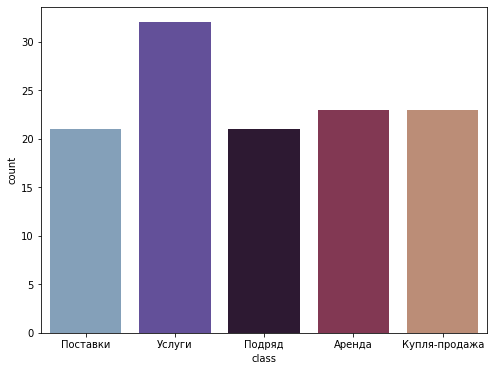

In [269]:
plt.figure(figsize=(8,6))
sns.countplot(x='class', data=labels, palette='twilight')

In [80]:
# d54c0b06162cf7cf57e8b1e7356aa204.docx
# не распознан текст, 2 столбца (1 - рус, 2 - англ)
data[data['lemma_text']=='']

,filename,class,extension,final_filename,abs_path,source_text,lemma_text,clean_text
26,d54c0b06162cf7cf57e8b1e7356aa204.doc,Услуги,doc,d54c0b06162cf7cf57e8b1e7356aa204.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,,,


In [81]:
data = data[~data['lemma_text'].isin([''])]

In [82]:
from PIL import Image
from wordcloud import WordCloud

In [103]:
def draw_word_cloud(df, doc_class):
    """Функция для отрисовки облаков слов"""
    text = ''
    for i in df[df['class']==doc_class]['lemma_text'].values:
        text += i+' '

    all_words = nltk.tokenize.word_tokenize(text.lower())
    all_words_no_stop = nltk.FreqDist(w.lower() for w in all_words if w not in russian_stopwords)

    wc = WordCloud(background_color="white", max_words=500,
                   stopwords=russian_stopwords, contour_width=4)

    wc.generate(" ".join(all_words_no_stop.keys()))

    plt.figure(figsize=(12, 8))
    plt.imshow(wc)
    plt.axis("off")

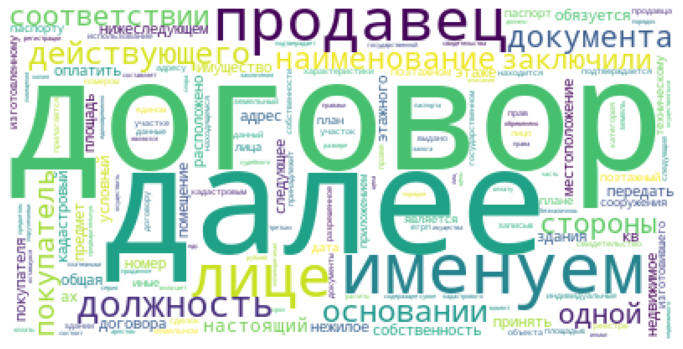

In [102]:
draw_word_cloud(data, 'Купля-продажа')

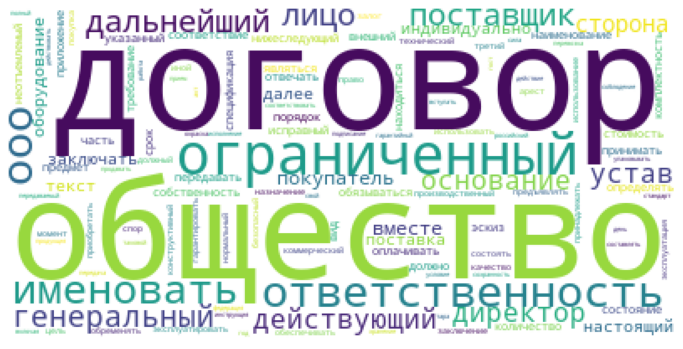

In [310]:
draw_word_cloud(data, 'Поставки')

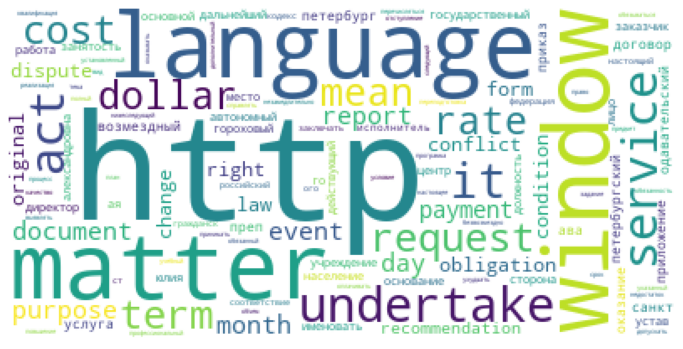

In [311]:
draw_word_cloud(data, 'Услуги')

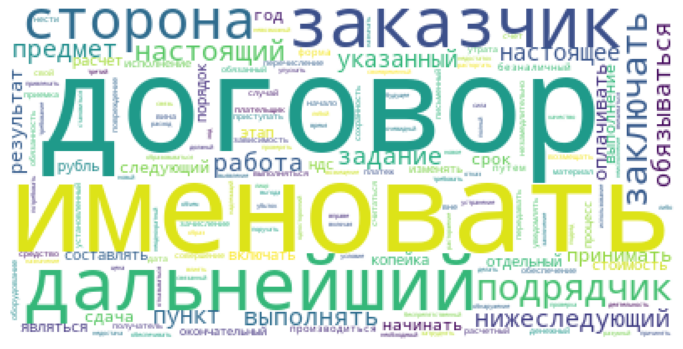

In [313]:
draw_word_cloud(data, 'Подряд')

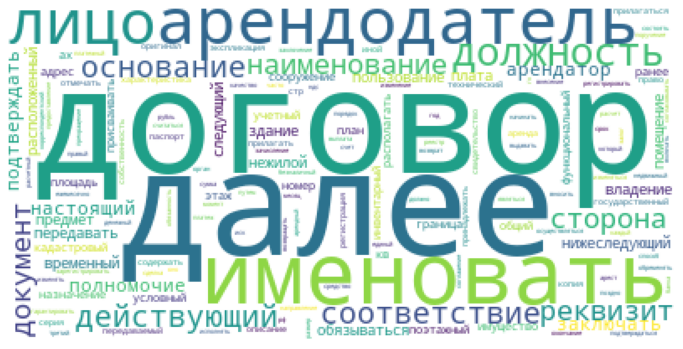

In [314]:
draw_word_cloud(data, 'Аренда')

## Бейзлайн
Расширим словарь стоп-слов, добавив туда наиболее частотные слова, встречающиеся во всех типах доков и не влиящих на тематику документа.


In [315]:
text = ''
for i in data['lemma_text'].values:
    text += i+' '

all_words = nltk.tokenize.word_tokenize(text.lower())
all_words_no_stop = nltk.FreqDist(w.lower() for w in all_words if w not in russian_stopwords)

In [317]:
all_words_no_stop.most_common(25)

[('договор', 5418),
 ('сторона', 3042),
 ('заказчик', 2050),
 ('настоящий', 1421),
 ('работа', 1417),
 ('срок', 1311),
 ('товар', 1243),
 ('исполнитель', 1240),
 ('покупатель', 1219),
 ('настоящее', 1140),
 ('услуга', 1038),
 ('случай', 1011),
 ('условие', 945),
 ('день', 924),
 ('исполнение', 793),
 ('поставщик', 764),
 ('акт', 754),
 ('подрядчик', 737),
 ('лицо', 725),
 ('обязательство', 700),
 ('порядок', 666),
 ('право', 645),
 ('который', 645),
 ('документ', 634),
 ('момент', 629)]

## Кросс-валидация

In [299]:
vect = TfidfVectorizer(ngram_range=(1, 4),max_features=1000)
rf = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=1)
pipe = make_pipeline(vect, rf)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

In [332]:
print('Результаты классификации на 5-фолдовой кросс-валидации')
for score in ['accuracy', 'precision_weighted', 
              'recall_weighted', 'f1_weighted']:
    cv_score = cross_val_score(pipe, data['lemma_text'], 
                               data['class'], cv=skfold, scoring=score)
    print('Mean {}: {}'.format(score, cv_score.mean()))
    print('StDev {}: {}'.format(score, cv_score.std()))
    print("********************************")

Результаты классификации на 5-фолдовой кросс-валидации
Mean accuracy: 0.9304347826086957
StDev accuracy: 0.06507230237867724
********************************
Mean precision_weighted: 0.9490269151138715
StDev precision_weighted: 0.04415803018553727
********************************
Mean recall_weighted: 0.9304347826086957
StDev recall_weighted: 0.06507230237867724
********************************
Mean f1_weighted: 0.9276906668211016
StDev f1_weighted: 0.06894889241831077
********************************


In [444]:
df_scores = pd.DataFrame({
    'score': ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
    'value': [93, 94.9, 93, 92.8]
})

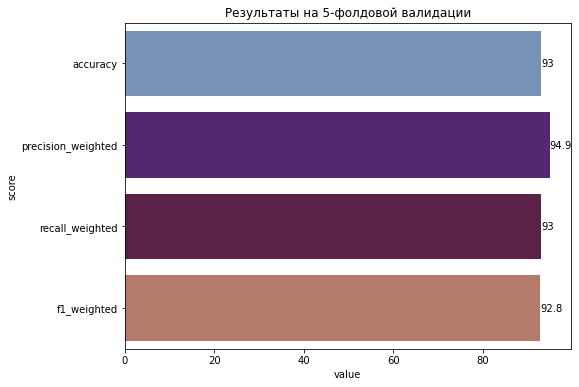

In [457]:
plt.figure(figsize=(8,6))
plt.title('Результаты на 5-фолдовой валидации')
ax = sns.barplot(y='score', x='value',data=df_scores, orient='h', palette='twilight')
ax.tick_params(axis='x', rotation=0)
for i in ax.containers:
    ax.bar_label(i,)
plt.savefig('5fold.png', bbox_inches='tight')

In [ ]:
####################### BASELINE MODEL #######################

In [300]:
train, test = train_test_split(data, test_size=0.3, stratify=data['class'], random_state=22)
train.shape, test.shape

((80, 8), (35, 8))

<AxesSubplot:xlabel='class', ylabel='count'>

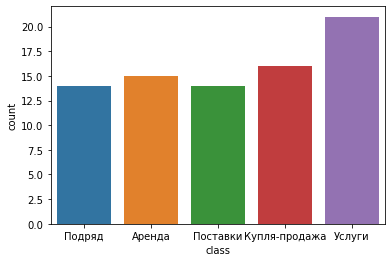

In [360]:
sns.countplot(x='class', data=train)

<AxesSubplot:xlabel='class', ylabel='count'>

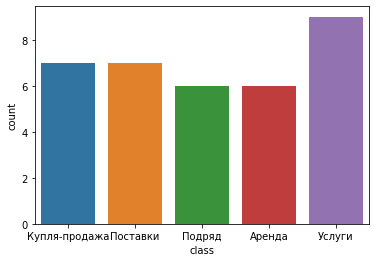

In [361]:
sns.countplot(x='class', data=test)

In [398]:
train[['clean_text', 'class']]

,clean_text,class
58,договор \n\n\n ...,Подряд
79,договор \nна сдачу помещений под офис ...,Аренда
3,договор поставки москва де...,Поставки
7,приложение \n приказу от ...,Поставки
113,договор \n\n\n ...,Купля-продажа
...,...,...
48,приложение \n\nдоговор \n\n мос...,Услуги
89,договор \n ...,Аренда
36,договор \n ...,Услуги
27,договор \n ...,Услуги


In [370]:
vect = TfidfVectorizer(ngram_range=(1, 4),max_features=1000)
rf = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=1)
pipe = make_pipeline(vect, rf)


pipe.fit(train['clean_text'], train['class'])
prediction = pipe.predict(test['clean_text'])
pred_proba = pipe.predict_proba(test['clean_text'])

In [371]:
print(classification_report(test['class'], prediction))

               precision    recall  f1-score   support

       Аренда       1.00      1.00      1.00         6
Купля-продажа       0.88      1.00      0.93         7
       Подряд       0.83      0.83      0.83         6
     Поставки       1.00      0.86      0.92         7
       Услуги       0.89      0.89      0.89         9

     accuracy                           0.91        35
    macro avg       0.92      0.92      0.92        35
 weighted avg       0.92      0.91      0.91        35



In [390]:
import pickle

pickle.dump(pipe, open('./models/model.pkl','wb'))

## Интерпретация с LIME 

In [424]:
test['prediction'] = prediction

In [436]:
test

,filename,class,extension,abs_path,source_text,lemma_text,prediction
118,2c81df29db63aebf495106881a52188f.docx,Купля-продажа,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,ДОГОВОР\n№ __\n\nг.________________\t\t\t\t\t\...,договор именовать дальнейший продавец лицо дей...,Купля-продажа
8,214d620d9c54bc83111277dd872d3cb2.pdf,Поставки,pdf,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,ДОГОВОР ПОСТАВКИ № ___________________________...,договор поставка поставка указываться предмет ...,Поставки
54,641282d3072e91ab05c97110e0340020.docx,Подряд,docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,ДОГОВОР № [Номер]\nОбщество с ограниченной отв...,договор номер общество ограниченный ответствен...,Подряд
20,856860329f573bbaf158e1eafa885ba5.docx,Поставки,docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,Договор поставки\n \nг. Новосибирск ...,договор поставка новосибирск именовать дальней...,Поставки
80,cf89a65d4477656ec05262ae55bb6aaa.docx,Аренда,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,"\nг. ____________\t""_____""____________200_г.\n...",собственник жилье свидетельство no копия свиде...,Аренда
115,f57fe87f15a6dee2b17e804421be63b5.pdf,Купля-продажа,pdf,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,Страница 1 из 8 \n \nДОГОВОР КУПЛИ -ПРОДАЖИ …...,договор купля продажа оборудование бывший упот...,Купля-продажа
73,c3141b7956167ce3987b82beb6cf73c4.docx,Подряд,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,\nДОГОВОР № ___________\n\nг. Москва\t«___» __...,договор москва акционерный общество всероссийс...,Подряд
30,317e4552102e82bd9e17ba1205cd4367.docx,Услуги,docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,Договор возмездного оказания услуг № {НомерДок...,договор возмездный оказание услуга номердокуме...,Услуги
44,910ccf7c9b029846e4390ddac5f8d687.docx,Услуги,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,ДОГОВОР №\n\nг._____________________\t\t\t\t\t...,договор организационно правовой форма юридичес...,Услуги
78,3588ff6fb8f5c5a5f70196500198ca3a.docx,Аренда,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,Договор № ____\n ...,договор далее именовать арендодатель лицо долж...,Аренда


In [425]:
test[test['class']!=test['prediction']]

,filename,class,extension,abs_path,source_text,lemma_text,prediction
31,67170dee29deff9bc80087a94aef7ea4.docx,Услуги,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,Договор № __\n\nг. Москва\t\t\t\t\t\t\t \t...,договор москва заказчик ооо компания заказчик ...,Подряд
14,4e583dc5a5f1499fd2408f3152589f2d.docx,Поставки,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,ПРОЕКТ ДОГОВОРА\n\n\nДоговор № _____________\n...,проект договор договор ставрополь год государс...,Услуги


In [426]:
class_names = pipe.classes_
class_names

array(['Аренда', 'Купля-продажа', 'Подряд', 'Поставки', 'Услуги'],
      dtype=object)

In [427]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=pipe.classes_)

In [437]:
# 118, 80
idx = 80

exp = explainer.explain_instance(test.loc[idx]['lemma_text'],
                                 pipe.predict_proba, num_features=6,
                                 top_labels=1)
print('Предсказанный класс:', class_names[exp.available_labels()])
print('Истинный класс: %s' % test.loc[idx]['class'])

Предсказанный класс: ['Аренда']
Истинный класс: Аренда


In [438]:
exp.show_in_notebook()

## Саммаризация

- extractive summarization
- abstractive summarization (more advanced)

In [481]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 1.0 MB/s eta 0:00:01


In [486]:
from transformers import MBartTokenizer, MBartForConditionalGeneration

In [487]:
model_name = "IlyaGusev/mbart_ru_sum_gazeta"
tokenizer = MBartTokenizer
.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)

TypeError: 'NoneType' object is not callable

In [490]:
!pip install pytextrank

     |████████████████████████████████| 47 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 34.3 MB 2.4 MB/s eta 0:00:011    |██████████████                  | 15.0 MB 6.9 MB/s eta 0:00:03
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3


    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.9.1 requires scikit-learn>=1.1.0, but you have scikit-learn 1.0.2 which is incompatible.
deeppavlov 1.0.1 requires scipy<1.9.0, but you have scipy 1.9.3 which is incompatible.


In [90]:
data['class'][0]

'Поставки'

In [91]:
import spacy
import pytextrank

# example text
text = data['clean_text'][0]

# load a spaCy model, depending on language, scale, etc.
nlp = spacy.load("ru_core_news_sm")

# add PyTextRank to the spaCy pipeline
nlp.add_pipe("textrank")
doc = nlp(text)

# examine the top-ranked phrases in the document
for phrase in doc._.phrases:
    print(phrase.text)
    print(phrase.rank, phrase.count)
    print(phrase.chunks)

российской федерации
0.032860977460515535 3
[российской федерации, российской федерации, российской федерации]
рф
0.030983654981935463 5
[рф, рф, рф, рф, рф]
арбитражный суд
0.022334036946143963 1
[арбитражный суд]
гк
0.02092246696111942 2
[гк, гк]
форсмажор
0.0181855278751872 1
[форсмажор]
москвы
0.01747956191919869 1
[москвы]
ооо
0.014804269847523473 1
[ооо]


In [93]:
!pip install summa

     |████████████████████████████████| 54 kB 751 kB/s eta 0:00:01
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54411 sha256=82e46bed9ed33901c6aa5ae8a4a197727e30d05e736b21aad309ead6de0280b8
  Stored in directory: /Users/mayabikmetova/Library/Caches/pip/wheels/ed/2c/5f/a0ccc5955d44d2cea78729f4425e73f818d2629517f7af0f8b
Successfully built summa


In [98]:
from summa import summarizer, keywords

text = data['source_text'][0]
summarizer.summarize(summarizer.summarize(text))

'"Стороны" "Договора" определили, что техническая и коммерческая эксплуатация приобретаемого "Оборудования" должна обеспечивать его нормальное и безопасное использование в соответствии с целями покупки его по "Договору".\nПринять "Оборудование" по количеству, качеству и комплектности в соответствии с условиями "Договора".\nПо своему выбору, потребовать оплаты "Оборудования" либо отказаться от исполнения "Договора", если "Покупатель" в нарушение "Договора" необоснованно отказывается принять и/или оплатить "Оборудование".\nПри передаче "Поставщиком" "Оборудования" ненадлежащего качества, в соответствии с условиями "Договора", если "Поставщик" не заменит "Оборудование" ненадлежащего качества в разумные сроки, потребовать безвозмездного устранения недостатков "Оборудования"в согласованный с "Поставщиком" срок, либо отказаться от «Оборудования» и воспользоваться ст.ст.\nВ случае существенного нарушения "Поставщиком" требований к качеству "Оборудования" (обнаружения неустранимых недостатков,

## Ключевые фразы по каждому классу

In [136]:
data['class'].unique()

array(['Поставки', 'Услуги', 'Подряд', 'Аренда', 'Купля-продажа'],
      dtype=object)

In [395]:
data.to_csv('DATA.csv', index=False)

In [381]:
# все классы

text = ''
for i in data['clean_text'].values:
    text += i+' '

all_w = nltk.tokenize.word_tokenize(text.lower())
all_w_b = nltk.FreqDist(nltk.bigrams(w.lower() for w in all_w))
all_w_t = nltk.FreqDist(nltk.trigrams(w.lower() for w in all_w))# if w not in russian_stopwords))

allcl = []


for k,v in dict(all_w_t.most_common(200)).items():
    allcl.append(' '.join(k))

In [382]:
def phrases_by_class(doc_class):
    
    # все классы
    text = ''
    for i in data['clean_text'].values:
        text += i+' '

    all_w = nltk.tokenize.word_tokenize(text.lower())
    all_w_b = nltk.FreqDist(nltk.bigrams(w.lower() for w in all_w))
    all_w_t = nltk.FreqDist(nltk.trigrams(w.lower() for w in all_w))# if w not in russian_stopwords))

    allcl = []
    for k,v in dict(all_w_t.most_common(200)).items():
        allcl.append(' '.join(k))

    
    # конкретный класс
    text = ''
    for i in data[data['class']==doc_class]['clean_text'].values:
        text += i+' '

    all_w = nltk.tokenize.word_tokenize(text.lower())
    all_w_b = nltk.FreqDist(nltk.bigrams(w.lower() for w in all_w))
    all_w_t = nltk.FreqDist(nltk.trigrams(w.lower() for w in all_w))# if w not in russian_stopwords))

    cl = []
    for k,v in dict(all_w_t.most_common(200)).items():
        cl.append(' '.join(k))
    
    diff_rent = set(cl) - set(allcl)
    return diff_rent

In [261]:
# def get_substrings(phrase, n):
#     phrase = phrase.split()
#     substrings = []
#     for i in range(len(phrase)):
#         if len(phrase[i:i+n]) == n:
#             substrings.append(' '.join(phrase[i:i+n]))
#     return substrings

# def phrases_by_class(doc_class):
#     texts = [i for i in data[data['class']==doc_class]['clean_text'].values]
    
#     ngrams_dict = {}
#     for i in texts:
# #         all_w = nltk.tokenize.word_tokenize(i)
# #         i_w = ' '.join([w for w in all_w if w not in russian_stopwords])
        
#         n_grams = get_substrings(i, 5)
#         for gram in n_grams:
#             if gram not in ngrams_dict.keys():
#                 ngrams_dict[gram] = 1
#             else:
#                 ngrams_dict[gram] += 1
    
#     final_dict = dict(sorted(ngrams_dict.items(), key=lambda item: item[1], reverse=True))
#     df = pd.DataFrame({'k':final_dict.keys(), 'v':final_dict.values()})
#     cl = df.head(50)['k'].values
        
#     diff_rent = set(cl) - set(allcl)
#     return diff_rent

In [386]:
def predict_with_keyphrases(doc):
    prediction, proba = pipe.predict([doc]), pipe.predict_proba([doc])
    print('Прогнозируемый тип договора: %s' %prediction[0])
    print('Прогнозная вероятность {}%'.format(round(max(proba[0])*100, 1)))
    print('')
    print('В документе встречаются следующие формулировки:')
    print('')
    for phrase in phrases_by_class(prediction[0]):
        if phrase in doc:
            print(phrase)
    print('**********************************************')
    print('')

In [394]:
pickle.load(open('./models/model.pkl', 'rb'))

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 4))),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=15, n_estimators=150,
                                        random_state=1))])

In [397]:
test[test['class']=='Услуги']

,filename,class,extension,final_filename,abs_path,source_text,lemma_text,clean_text
30,317e4552102e82bd9e17ba1205cd4367.docx,Услуги,docx,317e4552102e82bd9e17ba1205cd4367.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,Договор возмездного оказания услуг № {НомерДок...,договор возмездный оказание услуга номердокуме...,договор возмездного оказания услуг номердок...
44,910ccf7c9b029846e4390ddac5f8d687.doc,Услуги,doc,910ccf7c9b029846e4390ddac5f8d687.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,ДОГОВОР №\n\nг._____________________\t\t\t\t\t...,договор организационно правовой форма юридичес...,договор \n\n \t\t\t\t\t...
42,2060962a8b7ca4c45dc041c3f624225a.doc,Услуги,doc,2060962a8b7ca4c45dc041c3f624225a.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,Приложение № 9 к Приказу \n№ ______от ________...,приложение приказ договор москва год краткий п...,приложение приказу \n от ...
21,35b6a0f57d909507c5aa9a8972b15f35.pdf,Услуги,pdf,35b6a0f57d909507c5aa9a8972b15f35.pdf,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,Приложение № 6 \nк приказу от 29.12.2018 № 213...,приложение приказ ава договор возмездный оказа...,приложение \n приказу от ...
31,67170dee29deff9bc80087a94aef7ea4.doc,Услуги,doc,67170dee29deff9bc80087a94aef7ea4.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,Договор № __\n\nг. Москва\t\t\t\t\t\t\t \t...,договор москва заказчик ооо компания заказчик ...,договор \n\n москва\t\t\t\t\t\t\t \t...
35,eddc39f5f675890f285014c886bf22c9.doc,Услуги,doc,eddc39f5f675890f285014c886bf22c9.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,ДОГОВОР\n\n\nг. Москва\n«_____» ______________...,договор москва год гр рф год рождение фамилия ...,договор\n\n\n москва\n ...
22,f28d4a853be12515dae73a5912bc5b41.doc,Услуги,doc,f28d4a853be12515dae73a5912bc5b41.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,ДОГОВОР № ___________\n\nг. Новосибирск ...,договор новосибирск федеральный государственны...,договор \n\n новосибирск ...
45,82b672721c50b8897a3cf7c98c0d8e0c.rtf,Услуги,rtf,82b672721c50b8897a3cf7c98c0d8e0c.rtf,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,Приложение 3\nк приказу Минобразования России\...,приложение приказ минобразование россия пример...,приложение \n приказу минобразования россии\...
32,cbf3217807791a37499a7b8d94616fdc.doc,Услуги,doc,cbf3217807791a37499a7b8d94616fdc.docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,\nДОГОВОР\n№ ________\n\n\nг. Москва \t\t\t\t\...,договор москва полный краткий наименование име...,договор\n \n\n\n москва \t\t\t\t\t\...


In [387]:
for cl in test['class'].unique():
    print('Истинный тип договора: %s' %cl)
    mydoc = test[test['class']==cl]['clean_text'].iloc[0]
    predict_with_keyphrases(mydoc)

Истинный тип договора: Купля-продажа
Прогнозируемый тип договора: Купля-продажа
Прогнозная вероятность 62.7%

В документе встречаются следующие формулировки:

известить другую сторону
расчетный счет продавца
покупатель обязуется принять
собственности на товар
действия непреодолимой силы
**********************************************

Истинный тип договора: Поставки
Прогнозируемый тип договора: Поставки
Прогнозная вероятность 45.3%

В документе встречаются следующие формулировки:

товара по количеству
на складе поставщика
течение гарантийного срока
со склада поставщика
при приемке товара
полного исполнения сторонами
момента подписания сторонами
счет фактуру на
требовать от поставщика
**********************************************

Истинный тип договора: Подряд
Прогнозируемый тип договора: Подряд
Прогнозная вероятность 72.7%

В документе встречаются следующие формулировки:

срок для устранения
уполномоченными представителями сторон
случае нарушения подрядчиком
не зависящих от
по требован

In [399]:
!pip install KeyBERT

     |████████████████████████████████| 85 kB 964 kB/s eta 0:00:01
     |████████████████████████████████| 237 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 51 kB 4.3 MB/s eta 0:00:011
     |████████████████████████████████| 1.4 MB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 135.3 MB 7.2 MB/s eta 0:00:01   |                                | 450 kB 4.8 MB/s eta 0:00:28     |█                               | 4.1 MB 4.8 MB/s eta 0:00:28     |███                             | 12.6 MB 7.4 MB/s eta 0:00:17
  Created wheel for KeyBERT: filename=keybert-0.7.0-py3-none-any.whl size=23799 sha256=892a7213d5eb423a7833f4ea587e4040586b96c3bfda9e4f2ab55db4c52e9910
  Stored in directory: /Users/mayabikmetova/Library/Caches/pip/wheels/68/aa/41/82025d89b0eb97484c9ac7d527abf596765c41733af79f86b0
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125940 sha256=0dd37b5fa006576e0d565c163a34ed731a3c0b05d859aad06ad997d95e954

In [405]:
from keybert import KeyBERT

kw_model = KeyBERT("paraphrase-multilingual-MiniLM-L12-v2")

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [410]:
mydoc = test[test['class']=='Услуги']['clean_text'].iloc[0]

kw_model.extract_keywords(mydoc, keyphrase_ngram_range=(2, 4))

[('договора заказчик обязуется', 0.8177),
 ('указанные настоящего договора заказчик', 0.8155),
 ('указанной настоящего договора заказчик', 0.8145),
 ('настоящего договора заказчик обязуется', 0.8092),
 ('договора заказчик имеет', 0.8004)]

In [416]:
!export HOMEBREW_NO_AUTO_UPDATE=1
!brew install antiword

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Running `brew update --auto-update`...
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Casks
scrolla

You have 60 outdated formulae and 1 outdated cask installed.
You can upgrade them with brew upgrade
or list them with brew outdated.

==> Fetching antiword
==> Downloading https://ghcr.io/v2/homebrew/core/antiword

In [418]:
!antiword -f "/Users/mayabikmetova/Downloads/hacka-aka-embedika/docs/0ca2f9faecdbc67d6686a9f5b6636eba.doc" > file.txt



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [431]:
!nltk --version

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
nltk, version 3.7


In [426]:
with open("/Users/mayabikmetova/Downloads/hacka-aka-embedika/docs/0ca2f9faecdbc67d6686a9f5b6636eba.doc", 
         'rb') as f:
    old = f.read()

In [430]:
old.decode('utf-8')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd0 in position 0: invalid continuation byte

### RegEx для кодексов рф

Гражданский кодекс Российской Федерации (ГК РФ)

Трудовой кодекс Российской Федерации (ТК РФ)

Налоговый кодекс Российской Федерации (НК РФ)

Кодекс об административных правонарушениях Российской Федерации (КоАП РФ)

Уголовный кодекс Российской Федерации (УК РФ)

Гражданский процессуальный кодекс Российской Федерации (ГПК РФ)

Уголовно-процессуальный кодекс Российской Федерации (УПК РФ)

Арбитражный процессуальный кодекс Российской Федерации (АПК РФ)

Земельный кодекс Российской Федерации

Жилищный кодекс Российской Федерации (ЖК РФ)

Семейный кодекс Российской Федерации (СК РФ)

In [449]:
legal_codes = {'ГК РФ': 'Гражданский кодекс РФ',
          'ТК РФ': 'Трудовой кодекс РФ',
         'НК РФ': 'Налоговый кодекс РФ',
         'КоАП РФ': 'Кодекс об административных правонарушениях РФ',
         'УК РФ': 'Уголовный кодекс РФ',
         'ГПК РФ': 'Гражданский процессуальный кодекс РФ',
         'АПК РФ':'Арбитражный процессуальный кодекс РФ',
         'ЖК РФ': 'Жилищный кодекс РФ',
         'СК РФ': 'Семейный кодекс РФ'}

In [450]:
for i in legal_codes:
    print(i)

ГК РФ
ТК РФ
НК РФ
КоАП РФ
УК РФ
ГПК РФ
АПК РФ
ЖК РФ
СК РФ


In [451]:
def check_for_legal_codes(doc):
    found_codes = []
    for k, v in legal_codes.items():
        if k.lower() in doc:
            found_codes.append(v)
    
    return found_codes

In [453]:
data.iloc[83]['clean_text']

'договор\n\n\n                        \t                    \n\n     гражданин                                           проживающий по адресу                                                       документ  удостоверяющий личность               серия                              выдан                   \nименуемый   дальнейшем  арендодатель     одной стороны                   именуемое    дальнейшем  арендатор    лице генерального директора                    другой стороны  заключили настоящий договор   нижеследующем \n\nпредмет договора\n    арендодатель обязуется предоставить  во временное пользование арендатору техническое оборудование  сопровождаемые всеми принадлежностями   технической документацией  именуемые   дальнейшем  оборудование      арендатор принять   своевременно возвратить оборудование   исправном состоянии   учетом нормального износа   соответствии   номенклатурой  прилагаемой   настоящему договору   являющейся его неотъемлемой частью \n     доходы  полученные аренда

In [448]:
for i, row in enumerate(data['clean_text']):
    if 'ГПК РФ'.lower() in row:
        print(i)

83


In [462]:
check_for_legal_codes(data.iloc[2]['clean_text'])

['Гражданский кодекс РФ', 'Налоговый кодекс РФ']

In [463]:
data.iloc[2]

filename                      7eb67b5aecf3f3190aab0a5f8ea32172.docx
class                                                      Поставки
extension                                                      docx
final_filename                7eb67b5aecf3f3190aab0a5f8ea32172.docx
abs_path          /Users/mayabikmetova/xmas/hacka-aka-embedika/d...
source_text       \n\t\t\n\nДОГОВОР ЗАКУПКИ № __________/\n\nг.\...
lemma_text        договор закупка общество ограниченный ответств...
clean_text        договор закупки              \n\n  \t\t\t\t   ...
Name: 2, dtype: object

In [465]:
data['clean_text']

0      договор \n\n\nобщество   ограниченной ответств...
1      договор                \n\n\n дата  место закл...
2      договор закупки              \n\n  \t\t\t\t   ...
3      договор поставки        москва              де...
4      договор     номердокумента \n названиеконтр  и...
                             ...                        
115    страница   из   \n  \nдоговор купли  продажи  ...
116    договор\n\n   москва\n                        ...
117    предварительный договор\n\n   москва\n        ...
118    договор\n    \n\n                  \t\t\t\t\t\...
119    договор        \n\n   омск\t\t\t\t\t\t        ...
Name: clean_text, Length: 115, dtype: object

In [474]:
################### поиск % заимствований #######################

# исходная бд - train. Всё, что не в них - уникальность. Всё, что в них - заимстования.
# проверяем на заимствования - test

rent_lexica = set()
for text in train[train['class']=='Аренда']['lemma_text']:
    rent_lexica.update(set(text.split()))

In [476]:
len(rent_lexica)

1843

In [479]:
to_check = test[test['class']=='Аренда'].iloc[0]['lemma_text']

In [487]:
# уникальность 3%, вывод - типовой документ для класса "Аренда"

len(set(to_check.split()) - rent_lexica)/len(to_check.split()) *100

3.3734939759036147

In [ ]:
# Один раз просчитываем базу (train, 70% документов)

In [494]:
train['source'] = 'train'
test['source'] = 'test'

data_tt = pd.concat([train, test])

In [496]:
data_tt.columns

Index(['filename', 'class', 'extension', 'final_filename', 'abs_path',
       'source_text', 'lemma_text', 'clean_text', 'source'],
      dtype='object')

In [497]:
# data_tt.to_csv('DATA_TT.csv', index=False)

In [503]:
def create_lexica(fn):
    data = pd.read_csv(fn)
    
    lexica_dic = {}
    for cl in data['class'].unique():
        cur_df = data[(data['source']=='train') & (data['class']==cl)]
        
        lexicon = set()
        for text in cur_df['lemma_text']:
            lexicon.update(set(text.split()))
        lexica_dic[cl] = lexicon
    return lexica_dic

In [504]:
LEXICA = create_lexica('DATA_TT.csv')

In [533]:
def check_typicality(doc, doc_class):
    '''Наилучший результат достигается при использовании лемматизированных текстов'''
    tokenized = set(doc.split())
    uniq_percent = round(len(tokenized - LEXICA[doc_class])/len(tokenized) * 100, 1)
    
    if uniq_percent < 30:
        print('Уникальность текста составяет {}%. Типовой документ для класса "{}"'.format(uniq_percent, doc_class))
    else:
        print('Внимание! Уникальность - {}%. Высокая вероятность нетипичных условий.'.format(uniq_percent))
    

In [536]:
to_check = test[test['class']=='Купля-продажа'].iloc[1]['lemma_text']
check_typicality(to_check, 'Купля-продажа')

Внимание! Уникальность - 32.7%. Высокая вероятность нетипичных условий.


In [535]:
test[test['class']=='Купля-продажа'].iloc[1]

filename                       f57fe87f15a6dee2b17e804421be63b5.pdf
class                                                 Купля-продажа
extension                                                       pdf
final_filename                 f57fe87f15a6dee2b17e804421be63b5.pdf
abs_path          /Users/mayabikmetova/xmas/hacka-aka-embedika/d...
source_text       Страница 1 из 8 \n  \nДОГОВОР КУПЛИ -ПРОДАЖИ …...
lemma_text        договор купля продажа оборудование бывший упот...
clean_text        страница   из   \n  \nдоговор купли  продажи  ...
source                                                         test
Name: 115, dtype: object

In [528]:
DOC_PATH

'/Users/mayabikmetova/xmas/hacka-aka-embedika/docs'

In [531]:
# распределить документы по папкам трейн/тест, чтобы теститься только на ранее неиспользованных
# import shutil

# for i in data_tt[data_tt['source']=='train']['final_filename']:
#     shutil.copy(os.path.join(DOC_PATH, i), os.path.join(DOC_PATH, 'train', i))

# for i in data_tt[data_tt['source']=='test']['final_filename']:
#     shutil.copy(os.path.join(DOC_PATH, i), os.path.join(DOC_PATH, 'test', i))